# Comparación de PHL con otros métodos de selección de instancias

In [168]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt

# Set path to the notebook directory (Jupyter compatible)

dbnames = ['pima',
           'Dry bean',
           'diabetes_binary_5050split',
           'diabetes_binary'
]

dbpaths = ['../datasets/pima.csv',
           '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx',
           '../datasets/diabetes_health_indicators/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
           '../datasets/diabetes_health_indicators/diabetes_binary_health_indicators_BRFSS2015.csv'
]
targets = ['Outcome',
          'Class',
          'Diabetes_binary',
          'Diabetes_binary']

results_folders = ['../results/pima/',
                '../results/drybeans/',
                '../results/diabetes_binary_5050split/',
                '../results/diabetes_binary/']

In [169]:
def read_dataset(dbpath):
    if not os.path.exists(dbpath):
        print(f"{dbpath} does not exist.")
        return pd.DataFrame()

    # Load the dataset
    if dbpath.endswith('.xlsx') or dbpath.endswith('.xls'):
        # Read the Excel file
        df = pd.read_excel(dbpath, )
    else:
        # Read the CSV file
        df = pd.read_csv(dbpath)
    return df

dfs = [read_dataset(dbpath) for dbpath in dbpaths]
print("Tamaños de los datasets:")
for dbname, df in zip(dbnames, dfs):
    print(f"{dbname}: {df.shape}")

Tamaños de los datasets:
pima: (768, 9)
Dry bean: (13611, 17)
diabetes_binary_5050split: (70692, 22)
diabetes_binary: (253680, 22)


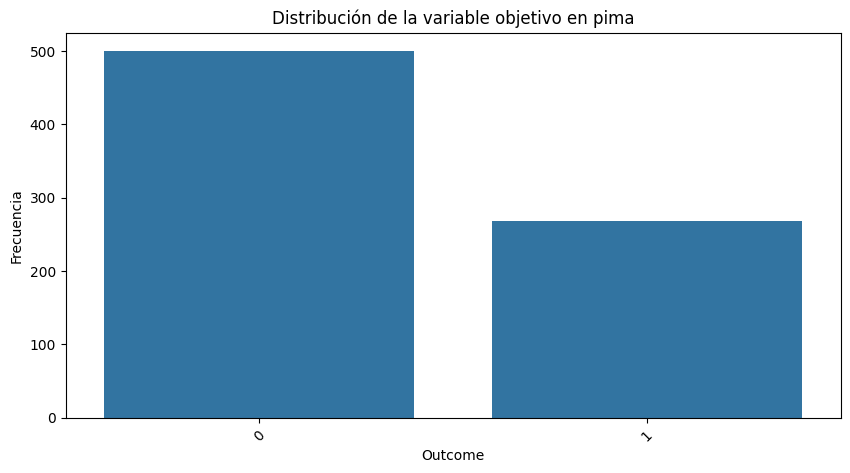

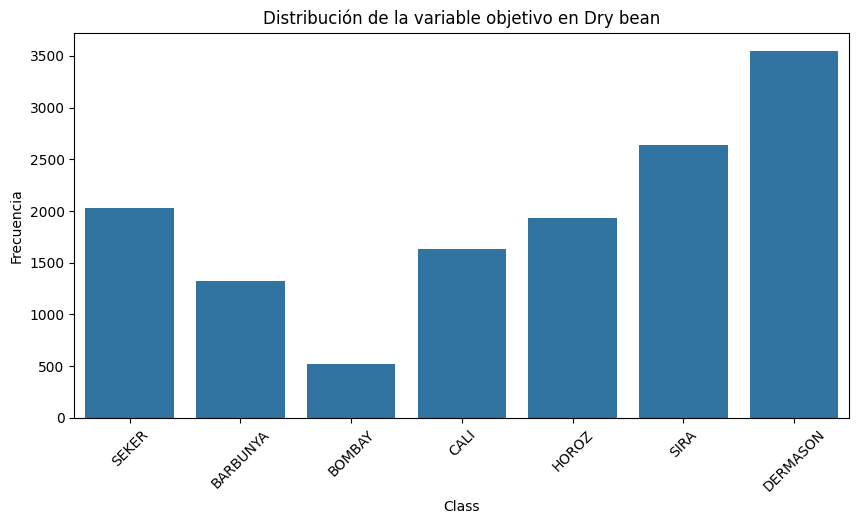

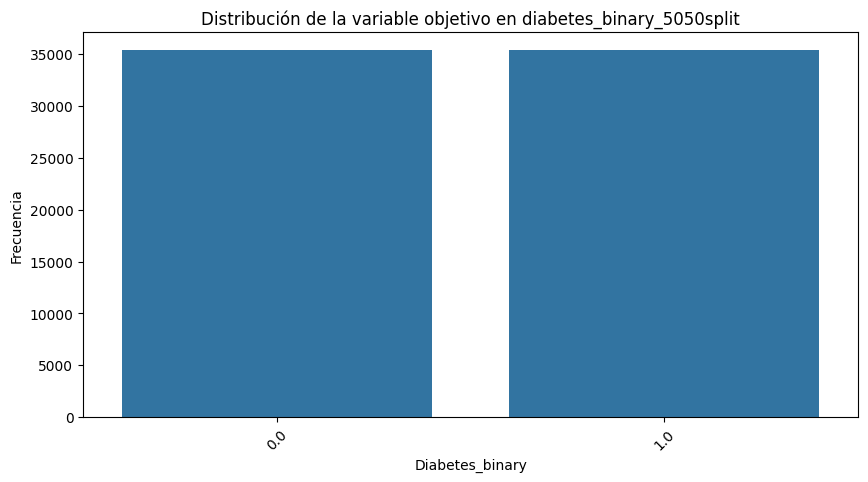

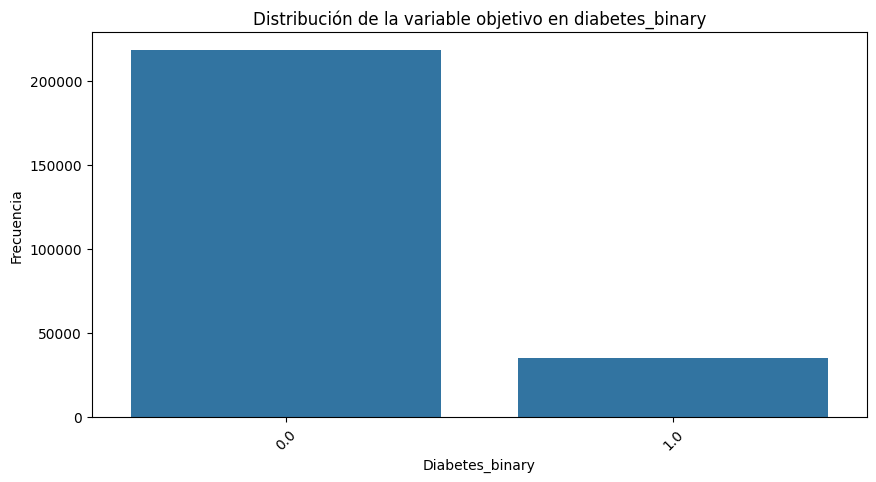

In [170]:
# Show bar plot of the target variable
for dbname, df, target in zip(dbnames, dfs, targets):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=target, data=df)
    plt.title(f'Distribución de la variable objetivo en {dbname}')
    plt.xlabel(target)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

## Comparación de métodos de selección de instancias

In [171]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
df_results = dict()
for dbname, results_folder in zip(dbnames, results_folders):
    df_results[dbname] = pd.read_csv(results_folder + 'results.csv')

### Dataset PIMA

In [172]:
results = df_results['pima']
results_folder = results_folders[0]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.714286,0.709411,0.001055,0.000000
1,RF,None,1.00,1.000000,0.000000,0.720779,0.714025,0.113521,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.753247,0.751855,0.064991,0.000000
3,KNN,SRS,0.05,0.048860,4.854175,0.681818,0.657571,0.000441,0.000648
4,KNN,SRS,0.10,0.097720,4.804304,0.655844,0.642750,0.000447,0.000634
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_R1_k=3,0.75,0.750814,2.956791,0.733766,0.732678,0.096607,0.130923
110,XGB,PHL_R1_k=3,0.75,0.750814,2.956791,0.759740,0.760521,0.034468,0.130923
111,KNN,PHL_R1_k=3,0.90,0.899023,3.305408,0.727273,0.724807,0.000747,0.130934
112,RF,PHL_R1_k=3,0.90,0.899023,3.305408,0.785714,0.781572,0.105000,0.130934


/tmp/ipykernel_9679/847241708.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


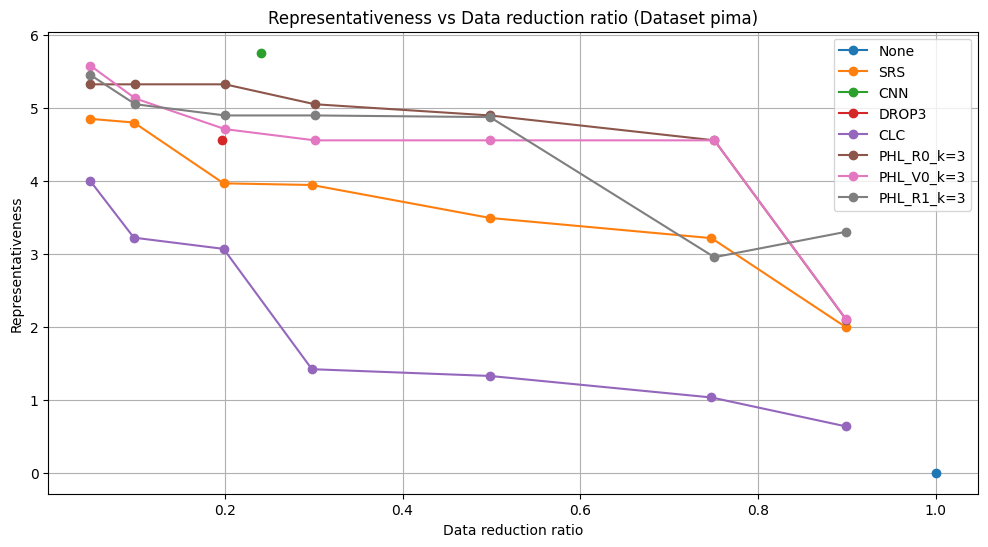

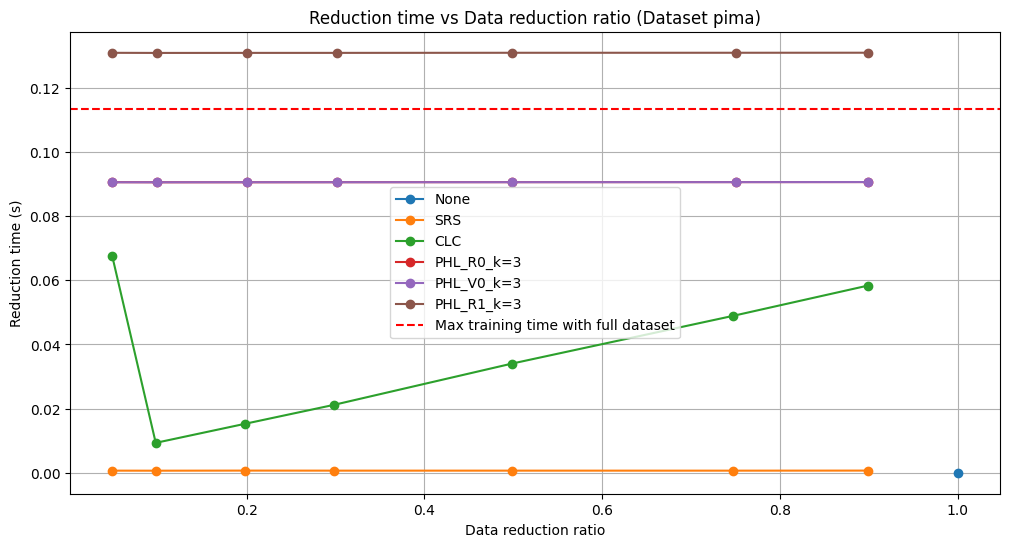

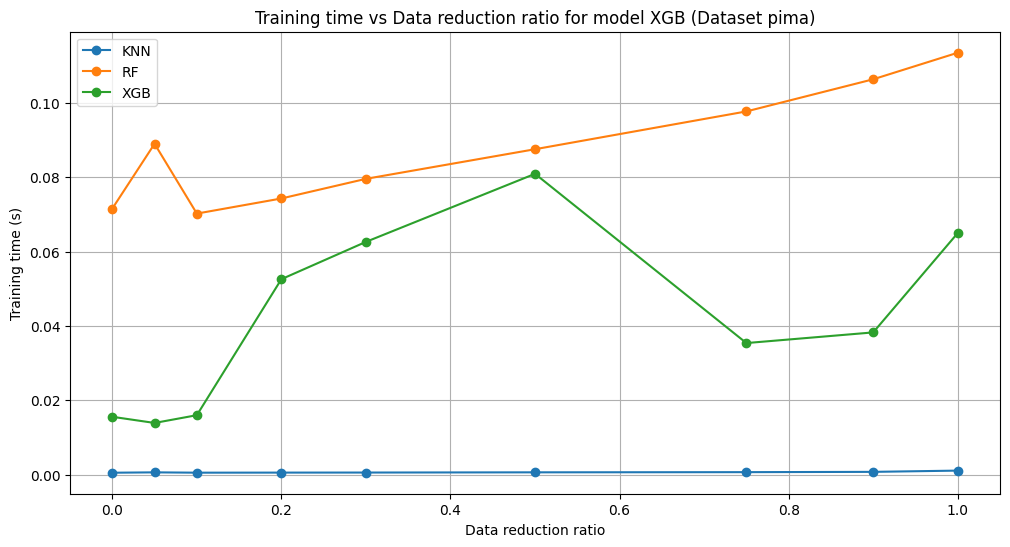

In [173]:
def plot_representativeness(dataset, exclude_representativeness=[], exclude_time = []):
    results = df_results[dataset]
    results_folder = results_folders[dbnames.index(dataset)]

    mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()
    mean_training_time = results.groupby(['model', 'percentage'])['training_time'].mean().reset_index()

    # Plot representativeness vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        if reduction_method not in exclude_representativeness:
            plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                    mean_results[mean_results['reduction_method'] == reduction_method]['representativeness'],
                    label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio (Dataset {dataset})')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
    plt.show()

    # Plot reduction time vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        if reduction_method not in exclude_time:
            plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                    mean_results[mean_results['reduction_method'] == reduction_method]['reduction_time'],
                    label=reduction_method, marker='o')
    plt.axhline(y=mean_training_time['training_time'].max(), color='r', linestyle='--', label='Max training time with full dataset')
    plt.title(f'Reduction time vs Data reduction ratio (Dataset {dataset})')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
    plt.show()

    # Plot training time vs percentage averaged by reduction method
    plt.figure(figsize=(12, 6))
    for model_name in results['model'].unique():
        if model_name not in exclude_time:
            plt.plot(mean_training_time[mean_training_time['model'] == model_name]['percentage'],
                    mean_training_time[mean_training_time['model'] == model_name]['training_time'],
                    label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio for model {model_name} (Dataset {dataset})')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
    plt.show()

plot_representativeness('pima', exclude_time=['CNN', 'DROP3'])

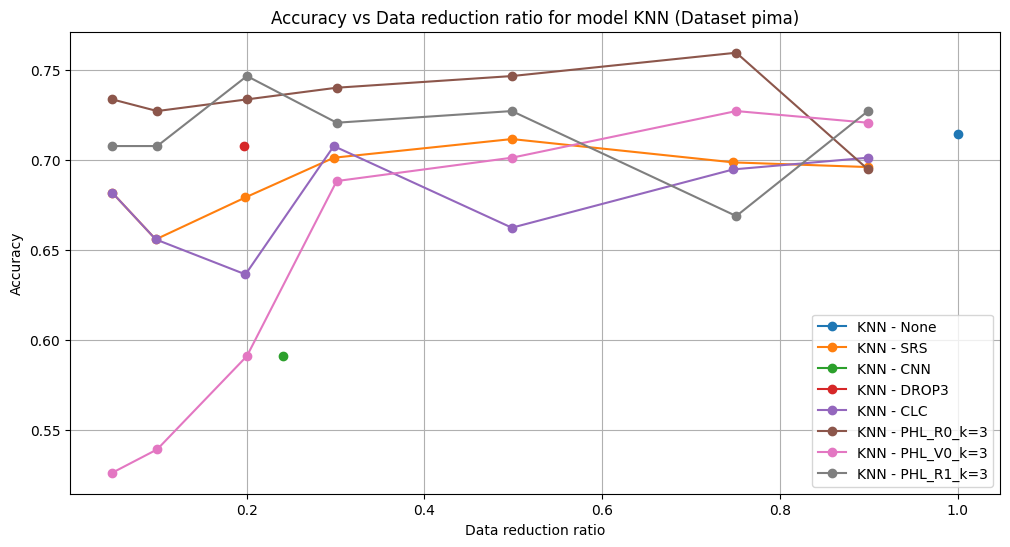

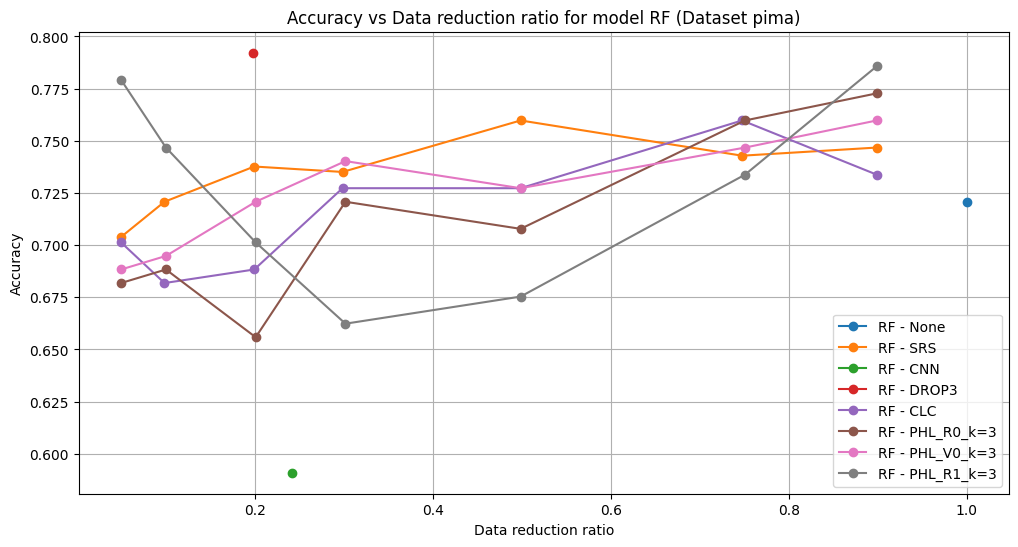

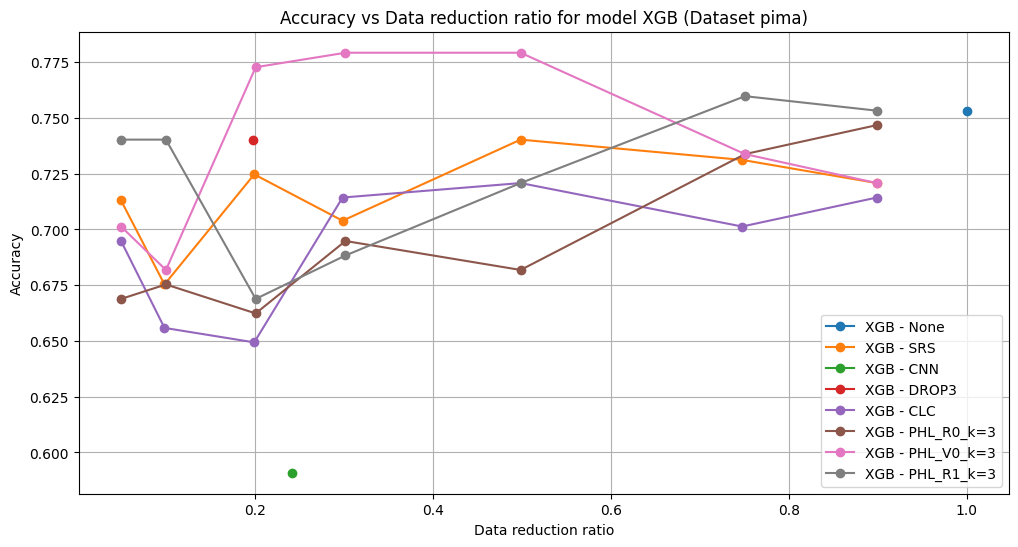

In [174]:
def plot_accuracy(dataset, exclude = []):
    results = df_results[dataset]
    results_folder = results_folders[dbnames.index(dataset)]

    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        for reduction_method in results['reduction_method'].unique():
            if reduction_method not in exclude:
                plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                        results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                        label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name} (Dataset {dataset})')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
        plt.show()

plot_accuracy('pima')

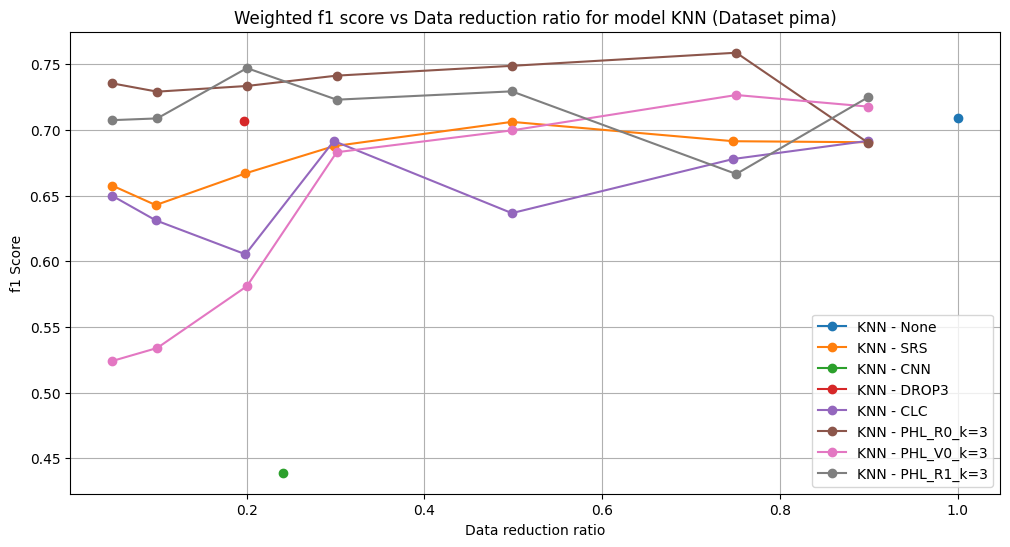

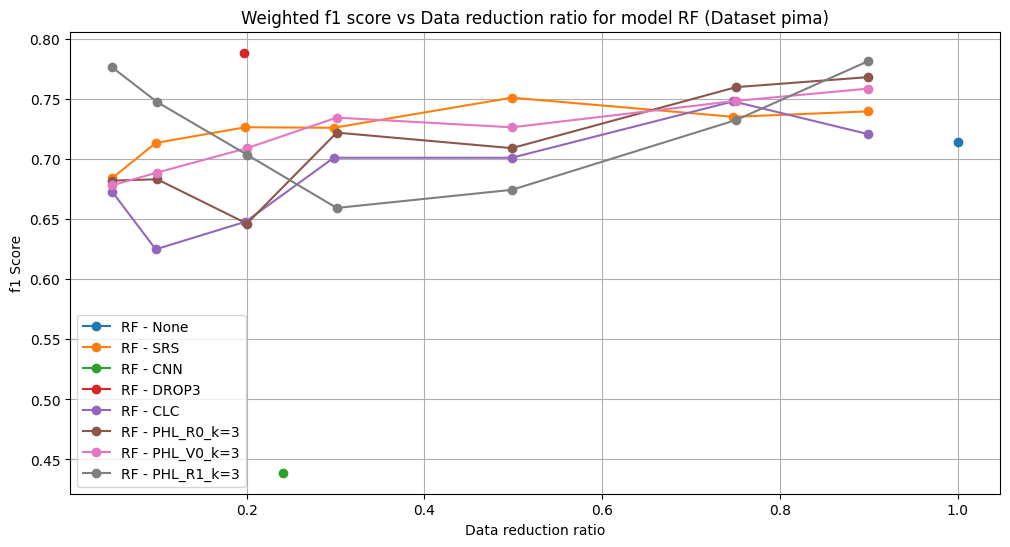

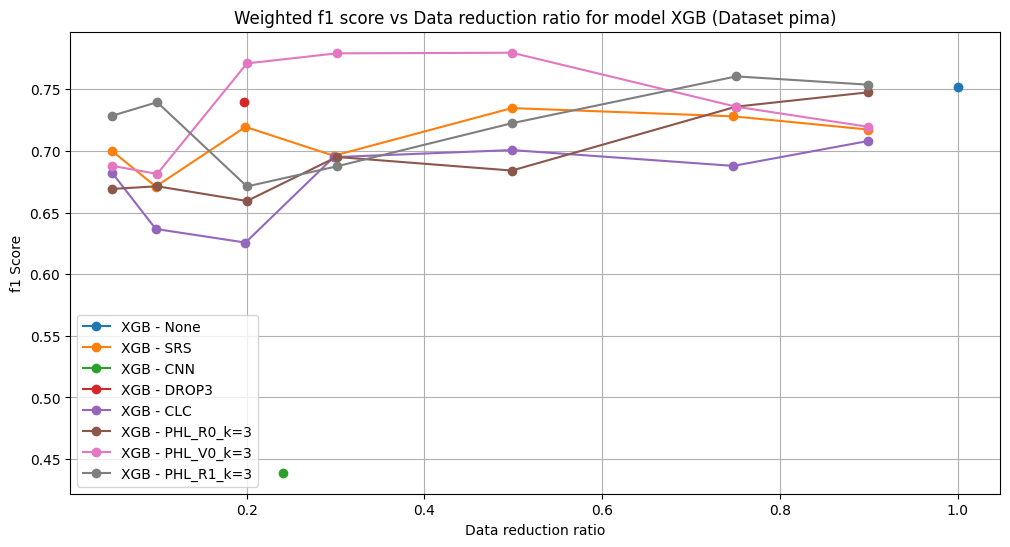

In [194]:
def plot_f1(dataset, exclude = []):
    results = df_results[dataset]
    results_folder = results_folders[dbnames.index(dataset)]
    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        for reduction_method in results['reduction_method'].unique():
            if reduction_method not in exclude:
                plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                        results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                        label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name} (Dataset {dataset})')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
        plt.show()

plot_f1('pima')

In [196]:
# Show results dataframe for pima and PHL methods
df_results['pima'][df_results['pima']['model'] == 'KNN']

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.714286,0.709411,0.001055,0.000000
3,KNN,SRS,0.05,0.048860,4.854175,0.681818,0.657571,0.000441,0.000648
4,KNN,SRS,0.10,0.097720,4.804304,0.655844,0.642750,0.000447,0.000634
5,KNN,SRS,0.20,0.198697,3.969961,0.679221,0.666914,0.000483,0.000664
6,KNN,SRS,0.30,0.298046,3.947210,0.701299,0.687591,0.000494,0.000650
7,KNN,SRS,0.50,0.498371,3.495061,0.711688,0.706110,0.000546,0.000649
8,KNN,SRS,0.75,0.747557,3.218043,0.698701,0.691373,0.000574,0.000645
9,KNN,SRS,0.90,0.899023,1.994336,0.696104,0.690591,0.000661,0.000665
24,KNN,CNN,0.00,0.241042,5.761741,0.590909,0.438961,0.000430,2.306311
27,KNN,DROP3,0.00,0.197068,4.559714,0.707792,0.706598,0.000541,0.945509


In [197]:
df_results['pima'][df_results['pima']['model'] == 'RF']

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
1,RF,None,1.00,1.000000,0.000000,0.720779,0.714025,0.113521,0.000000
10,RF,SRS,0.05,0.048860,4.854175,0.703896,0.684356,0.069155,0.000648
11,RF,SRS,0.10,0.097720,4.804304,0.720779,0.713521,0.070407,0.000634
12,RF,SRS,0.20,0.198697,3.969961,0.737662,0.726617,0.076258,0.000664
13,RF,SRS,0.30,0.298046,3.947210,0.735065,0.726165,0.085892,0.000650
14,RF,SRS,0.50,0.498371,3.495061,0.759740,0.751239,0.089369,0.000649
15,RF,SRS,0.75,0.747557,3.218043,0.742857,0.735292,0.098216,0.000645
16,RF,SRS,0.90,0.899023,1.994336,0.746753,0.739826,0.105493,0.000665
25,RF,CNN,0.00,0.241042,5.761741,0.590909,0.438961,0.069399,2.306311
28,RF,DROP3,0.00,0.197068,4.559714,0.792208,0.788662,0.073747,0.945509


In [198]:
df_results['pima'][df_results['pima']['model'] == 'XGB']

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
2,XGB,None,1.00,1.000000,0.000000,0.753247,0.751855,0.064991,0.000000
17,XGB,SRS,0.05,0.048860,4.854175,0.712987,0.699835,0.014231,0.000648
18,XGB,SRS,0.10,0.097720,4.804304,0.675325,0.671137,0.016298,0.000634
19,XGB,SRS,0.20,0.198697,3.969961,0.724675,0.719523,0.182349,0.000664
20,XGB,SRS,0.30,0.298046,3.947210,0.703896,0.696139,0.219705,0.000650
21,XGB,SRS,0.50,0.498371,3.495061,0.740260,0.734799,0.286480,0.000649
22,XGB,SRS,0.75,0.747557,3.218043,0.731169,0.728104,0.040264,0.000645
23,XGB,SRS,0.90,0.899023,1.994336,0.720779,0.717400,0.041939,0.000665
26,XGB,CNN,0.00,0.241042,5.761741,0.590909,0.438961,0.010835,2.306311
29,XGB,DROP3,0.00,0.197068,4.559714,0.740260,0.739577,0.020244,0.945509


### Dataset DryBeans

In [176]:
results = df_results['Dry bean']
results_folder = results_folder[1]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.918840,0.919008,0.001121,0.000000
1,RF,None,1.00,1.000000,0.000000,0.922879,0.922812,3.371022,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.920676,0.920778,0.531868,0.000000
3,KNN,SRS,0.05,0.049596,13.460832,0.899008,0.899391,0.000369,0.003635
4,KNN,SRS,0.10,0.099743,10.810566,0.902167,0.902509,0.000390,0.003608
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_R1_k=3,0.75,0.750000,12.640035,0.921043,0.921281,2.265294,2.449526
110,XGB,PHL_R1_k=3,0.75,0.750000,12.640035,0.920676,0.921078,0.447789,2.449526
111,KNN,PHL_R1_k=3,0.90,0.900073,10.841108,0.919207,0.919445,0.000836,2.449873
112,RF,PHL_R1_k=3,0.90,0.900073,10.841108,0.923981,0.923930,2.897516,2.449873


/tmp/ipykernel_9679/847241708.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


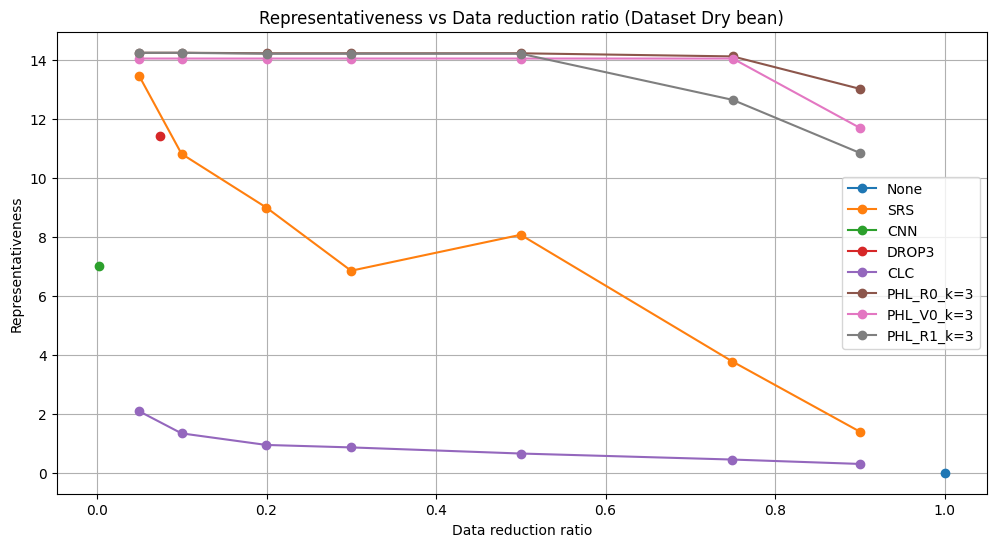

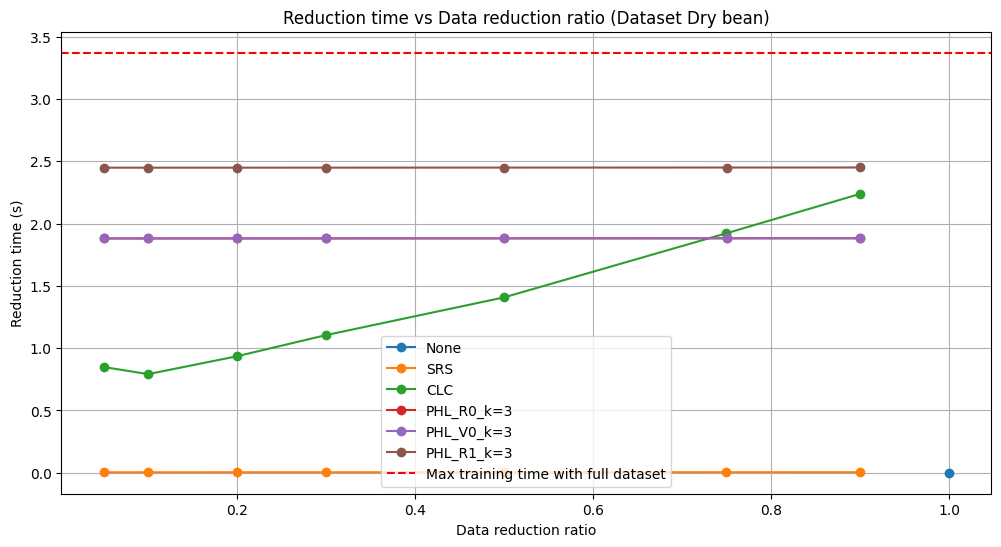

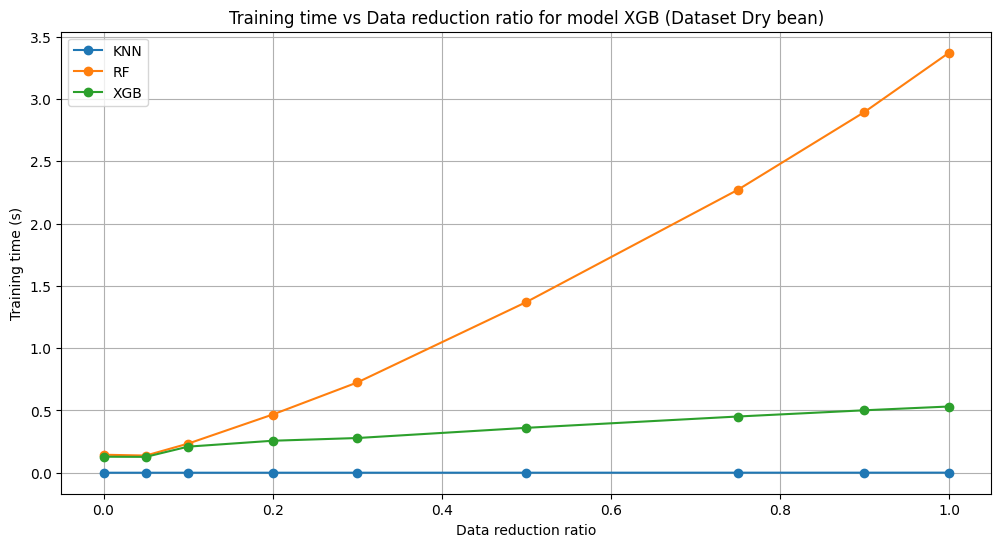

In [177]:
plot_representativeness('Dry bean', exclude_time=['CNN', 'DROP3'])

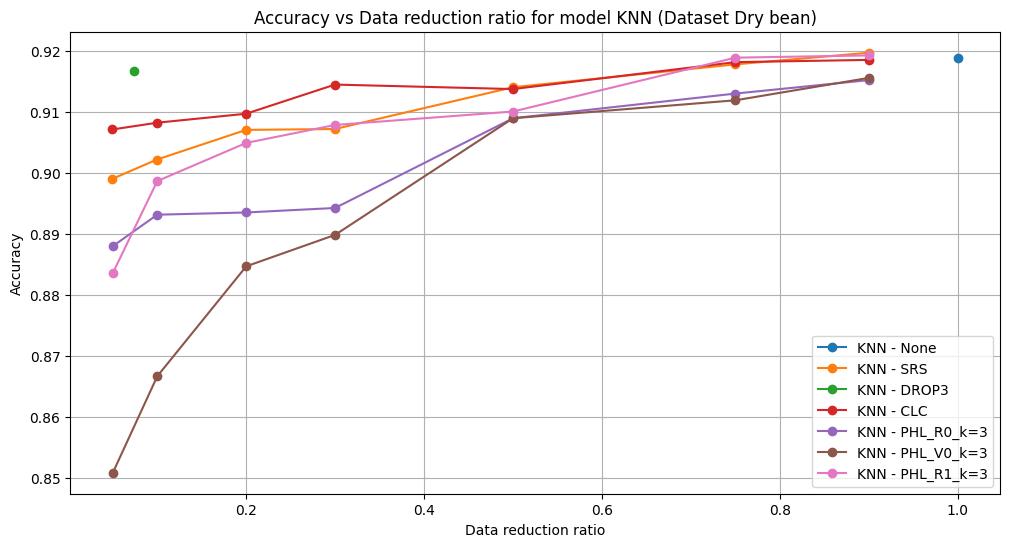

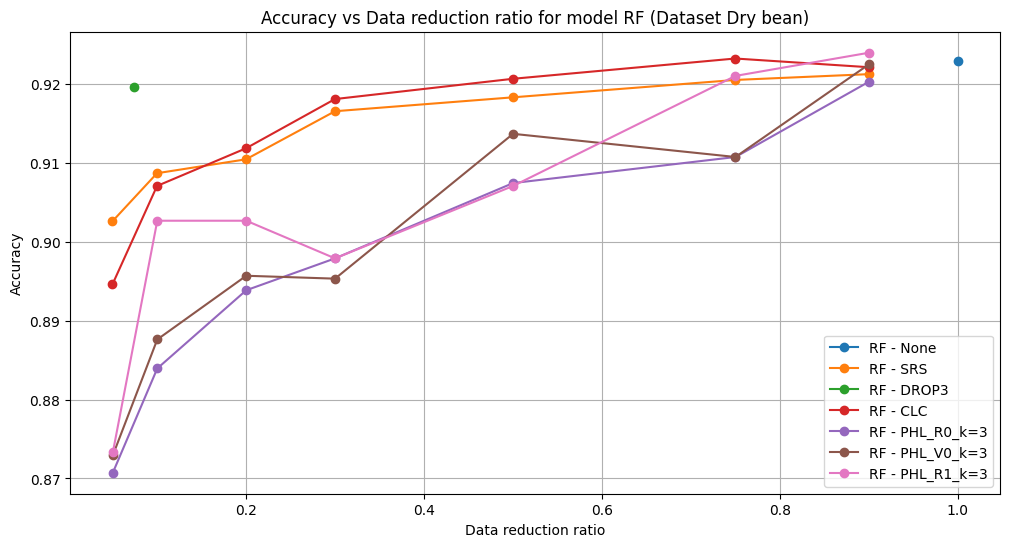

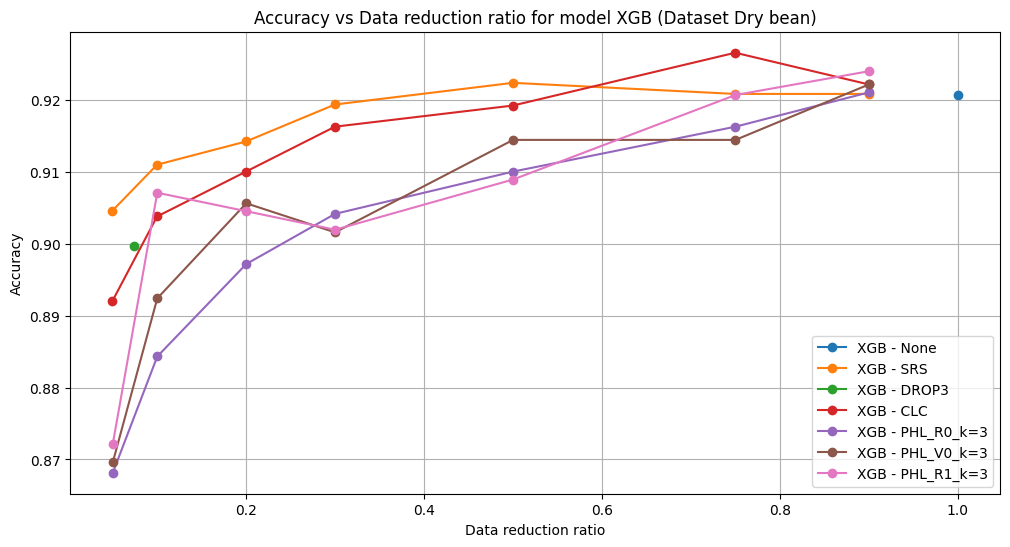

In [178]:
plot_accuracy('Dry bean', exclude=['CNN'])

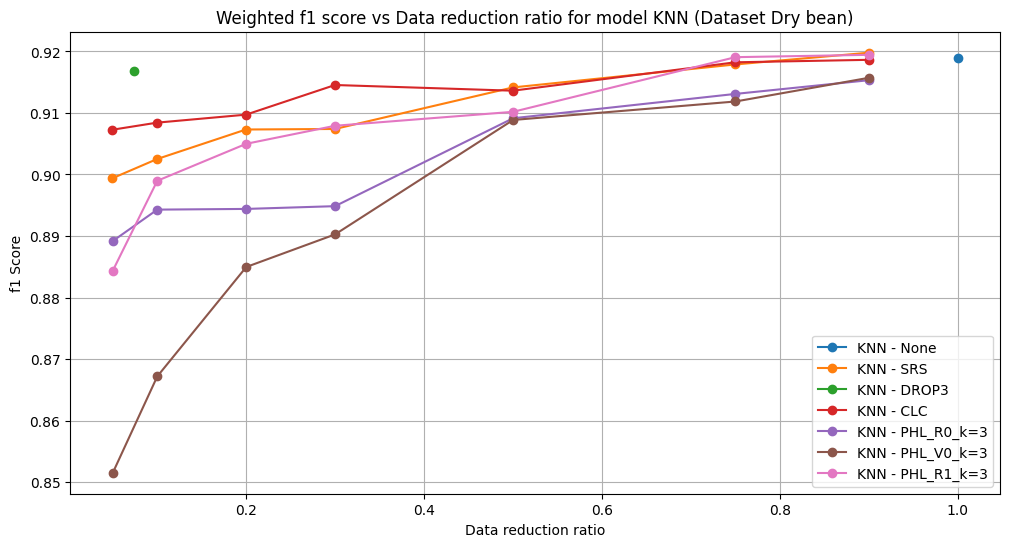

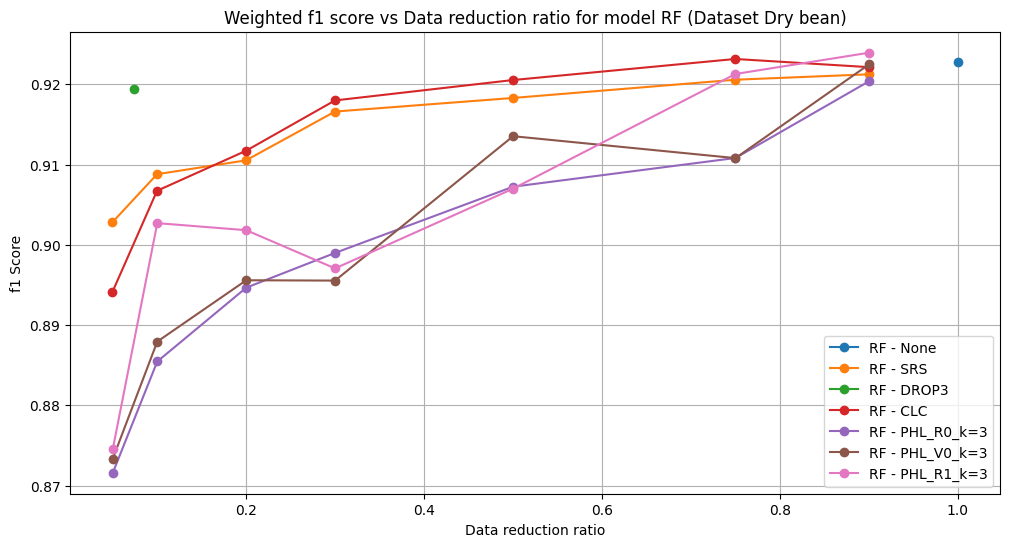

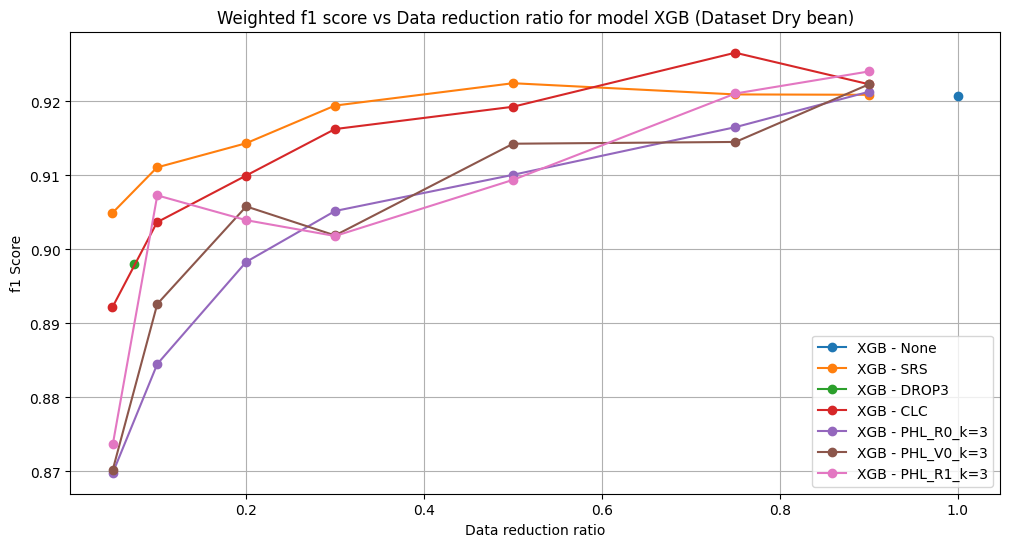

In [179]:
plot_f1('Dry bean', exclude=['CNN'])

In [200]:
df_results['Dry bean'][df_results['Dry bean']['reduction_method'] == 'CNN']

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
24,KNN,CNN,0.0,0.002572,7.00934,0.703636,0.690702,0.000380,0.262908
25,RF,CNN,0.0,0.002572,7.00934,0.769372,0.770203,0.070171,0.262908
26,XGB,CNN,0.0,0.002572,7.00934,0.714653,0.708814,0.055148,0.262908


In [203]:
df_results['Dry bean'][(df_results['Dry bean']['reduction_method'] == 'DROP3') | (df_results['Dry bean']['reduction_method'] == 'None')]

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.0,1.00000,0.000000,0.918840,0.919008,0.001121,0.00000
1,RF,None,1.0,1.00000,0.000000,0.922879,0.922812,3.371022,0.00000
2,XGB,None,1.0,1.00000,0.000000,0.920676,0.920778,0.531868,0.00000
27,KNN,DROP3,0.0,0.07421,11.428036,0.916636,0.916788,0.000471,77.74027
28,RF,DROP3,0.0,0.07421,11.428036,0.919574,0.919380,0.219335,77.74027
29,XGB,DROP3,0.0,0.07421,11.428036,0.899743,0.897993,0.202829,77.74027


In [201]:
df_results['Dry bean'][df_results['Dry bean']['reduction_method'] == 'SRS']

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
3,KNN,SRS,0.05,0.049596,13.460832,0.899008,0.899391,0.000369,0.003635
4,KNN,SRS,0.10,0.099743,10.810566,0.902167,0.902509,0.000390,0.003608
5,KNN,SRS,0.20,0.199761,8.989926,0.907014,0.907311,0.000444,0.003715
6,KNN,SRS,0.30,0.299780,6.847538,0.907161,0.907396,0.000476,0.003733
7,KNN,SRS,0.50,0.499816,8.065822,0.913992,0.914146,0.000558,0.003823
8,KNN,SRS,0.75,0.749724,3.768813,0.917738,0.917881,0.000667,0.004060
9,KNN,SRS,0.90,0.899706,1.396392,0.919647,0.919786,0.000715,0.004125
10,RF,SRS,0.05,0.049596,13.460832,0.902607,0.902803,0.142634,0.003635
11,RF,SRS,0.10,0.099743,10.810566,0.908704,0.908790,0.248530,0.003608
12,RF,SRS,0.20,0.199761,8.989926,0.910466,0.910518,0.501381,0.003715


In [204]:
df_results['Dry bean'][df_results['Dry bean']['percentage'] == 0.9]

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
9,KNN,SRS,0.9,0.899706,1.396392,0.919647,0.919786,0.000715,0.004125
16,RF,SRS,0.9,0.899706,1.396392,0.921263,0.921238,2.946690,0.004125
23,XGB,SRS,0.9,0.899706,1.396392,0.920823,0.920902,0.522186,0.004125
48,KNN,CLC,0.9,0.899706,0.298190,0.918472,0.918632,0.000924,2.237225
49,RF,CLC,0.9,0.899706,0.298190,0.922145,0.922134,2.947344,2.237225
50,XGB,CLC,0.9,0.899706,0.298190,0.922145,0.922336,0.503457,2.237225
87,KNN,PHL_R0_k=3,0.9,0.900073,13.013647,0.915167,0.915324,0.000857,1.881869
88,RF,PHL_R0_k=3,0.9,0.900073,13.013647,0.920308,0.920371,2.840143,1.881869
89,XGB,PHL_R0_k=3,0.9,0.900073,13.013647,0.921043,0.921314,0.491529,1.881869
90,KNN,PHL_V0_k=3,0.9,0.900073,11.690158,0.915534,0.915717,0.000859,1.881891


In [205]:
df_results['Dry bean'][df_results['Dry bean']['percentage'] == 0.05]

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
3,KNN,SRS,0.05,0.049596,13.460832,0.899008,0.899391,0.000369,0.003635
10,RF,SRS,0.05,0.049596,13.460832,0.902607,0.902803,0.142634,0.003635
17,XGB,SRS,0.05,0.049596,13.460832,0.904591,0.904934,0.150511,0.003635
30,KNN,CLC,0.05,0.049596,2.086126,0.907088,0.907274,0.000473,0.848497
31,RF,CLC,0.05,0.049596,2.086126,0.894602,0.894118,0.147097,0.848497
32,XGB,CLC,0.05,0.049596,2.086126,0.892031,0.892190,0.155203,0.848497
51,KNN,PHL_R0_k=3,0.05,0.050055,14.238720,0.887991,0.889196,0.000478,1.880332
52,RF,PHL_R0_k=3,0.05,0.050055,14.238720,0.870731,0.871594,0.129133,1.880332
53,XGB,PHL_R0_k=3,0.05,0.050055,14.238720,0.868160,0.869827,0.094509,1.880332
54,KNN,PHL_V0_k=3,0.05,0.050055,14.041504,0.850900,0.851545,0.000485,1.880371


### Dataset Diabetes binary 5050split

In [180]:
results = df_results['diabetes_binary_5050split']
results_folder = results_folders[2]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.693472,0.693427,0.003358,0.000000
1,RF,None,1.00,1.000000,0.000000,0.741920,0.741696,4.406139,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.747295,0.747000,0.146993,0.000000
3,KNN,SRS,0.05,0.049989,6.304665,0.689964,0.689944,0.000504,0.015696
4,KNN,SRS,0.10,0.099995,5.077813,0.694363,0.694333,0.000589,0.015869
...,...,...,...,...,...,...,...,...,...
103,RF,PHL_R1_k=3,0.75,0.749987,4.132581,0.737959,0.737211,2.932779,534.060951
104,XGB,PHL_R1_k=3,0.75,0.749987,4.132581,0.745031,0.744220,0.105047,534.060951
105,KNN,PHL_R1_k=3,0.90,0.900005,4.816520,0.696584,0.696504,0.002728,534.062641
106,RF,PHL_R1_k=3,0.90,0.900005,4.816520,0.741000,0.740682,3.623314,534.062641


/tmp/ipykernel_9679/847241708.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


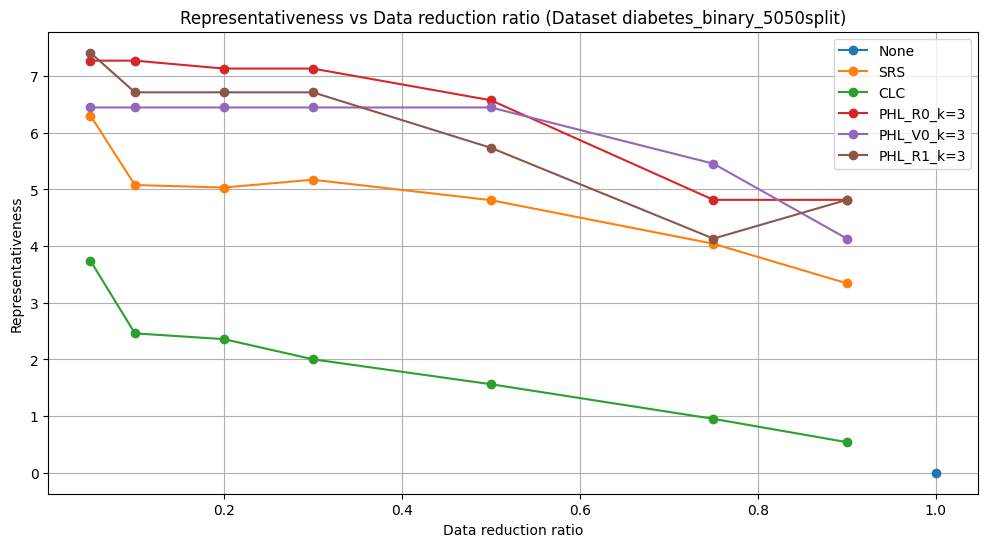

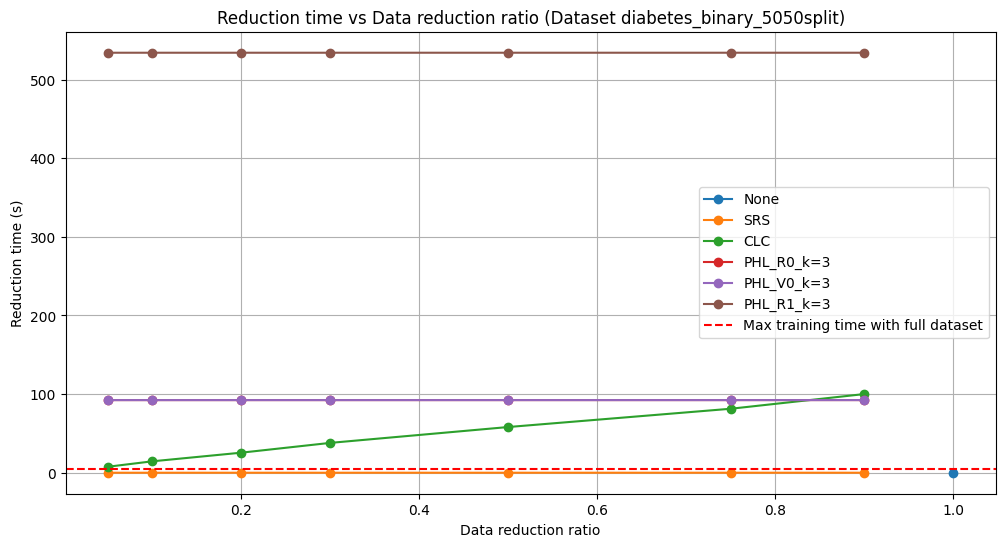

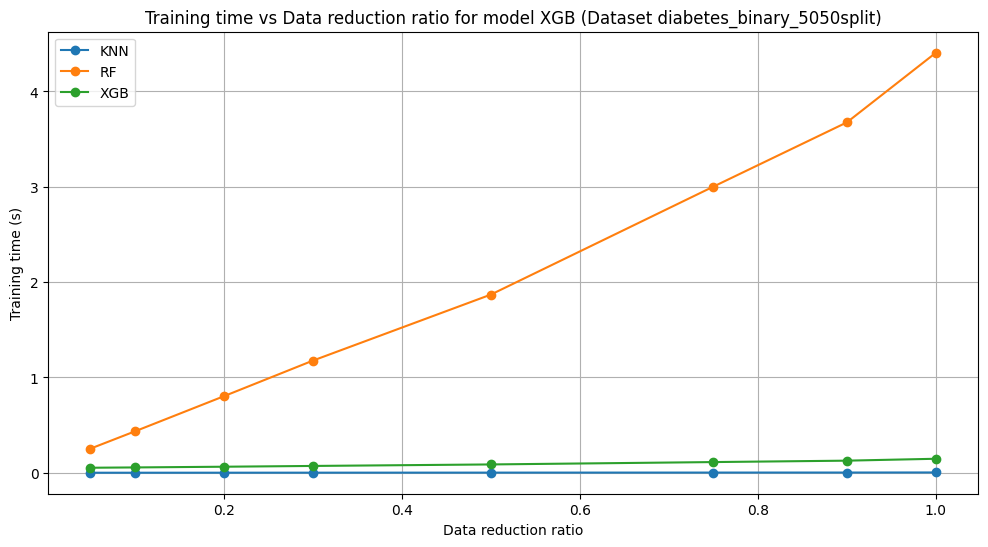

In [181]:
plot_representativeness('diabetes_binary_5050split')

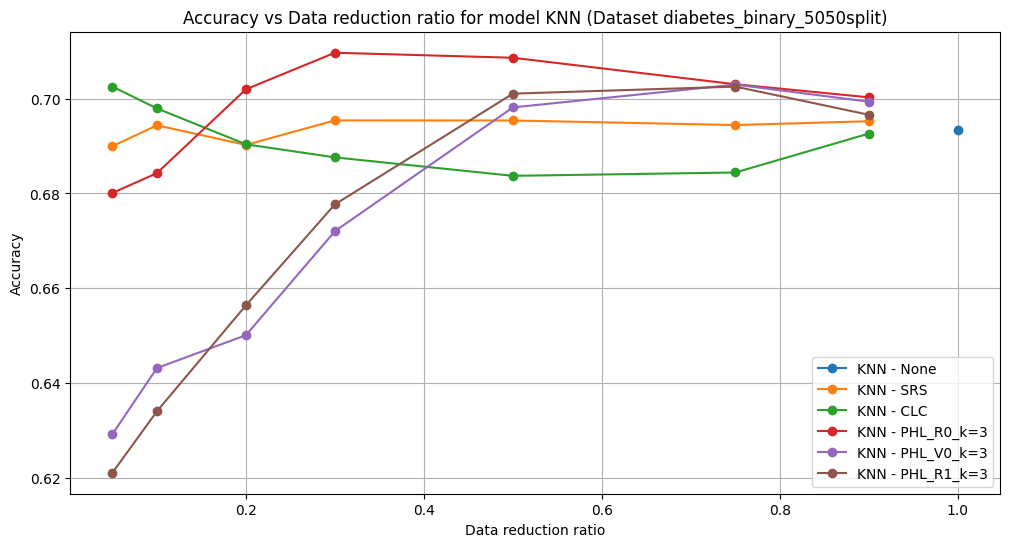

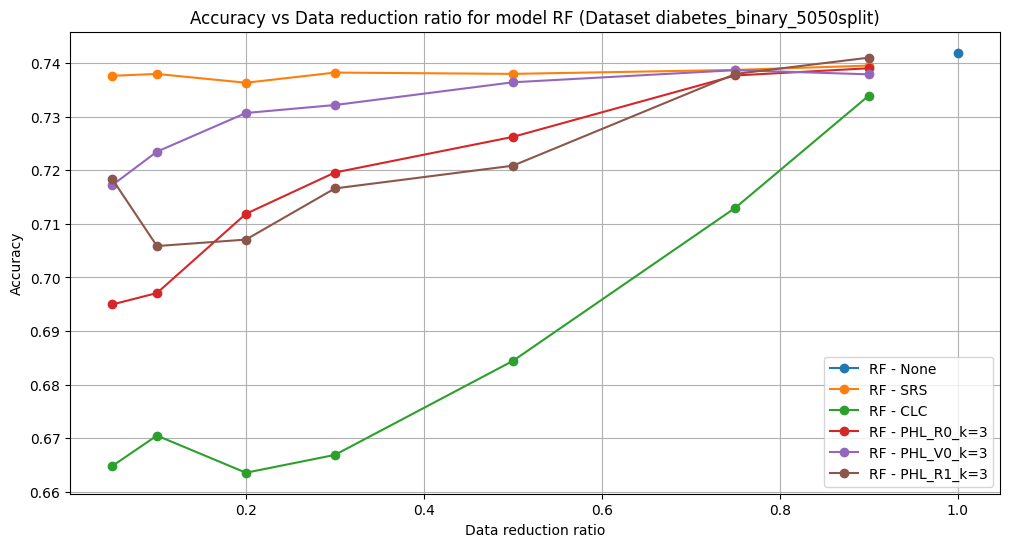

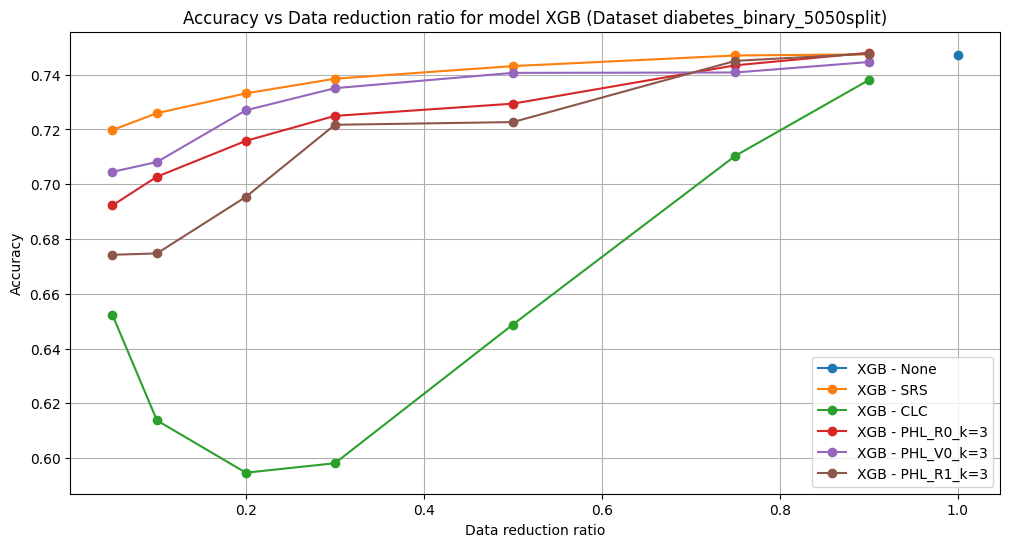

In [182]:
plot_accuracy('diabetes_binary_5050split')

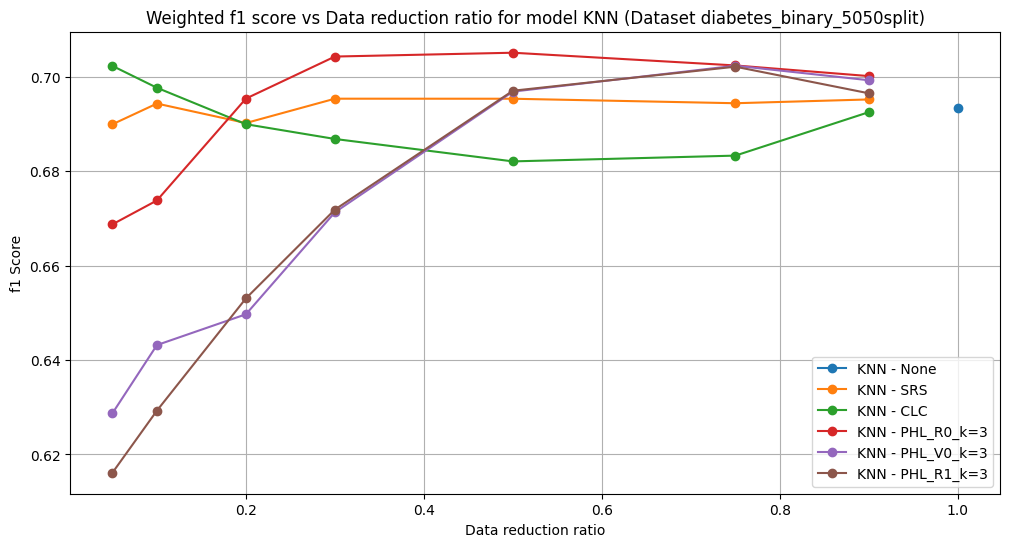

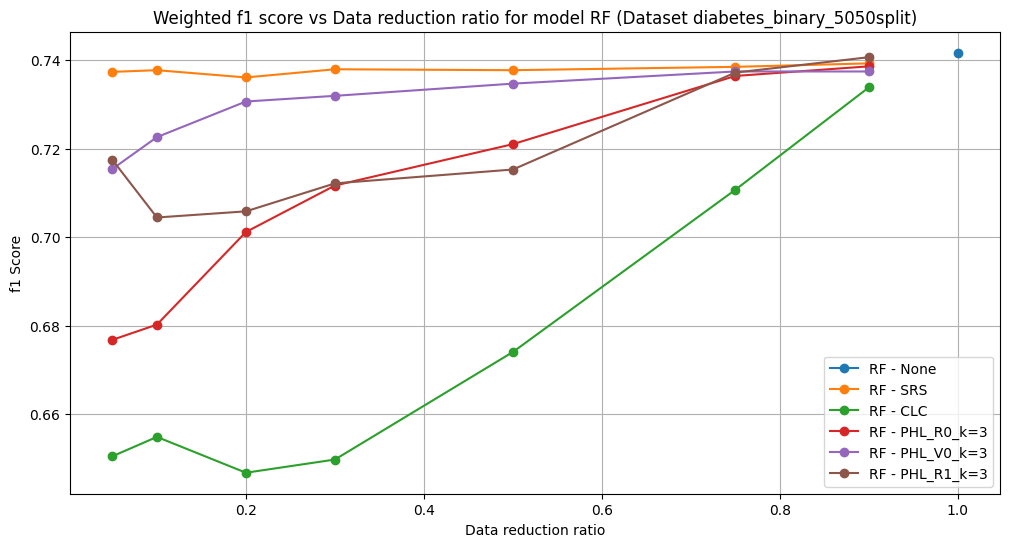

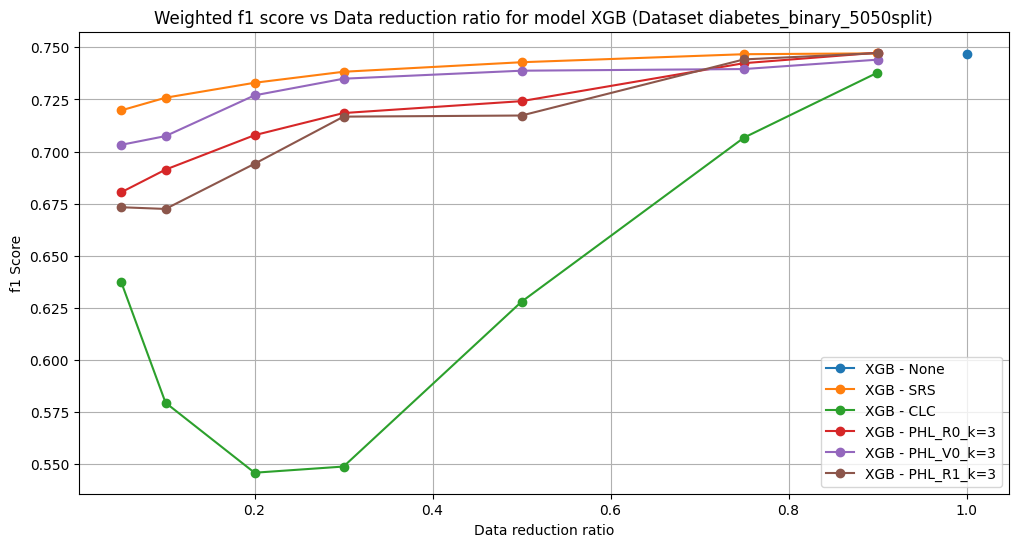

In [183]:
plot_f1('diabetes_binary_5050split')

In [207]:
df_results['diabetes_binary_5050split'][df_results['diabetes_binary_5050split']['percentage'] == 0.05]

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
3,KNN,SRS,0.05,0.049989,6.304665,0.689964,0.689944,0.000504,0.015696
10,RF,SRS,0.05,0.049989,6.304665,0.737619,0.737367,0.223292,0.015696
17,XGB,SRS,0.05,0.049989,6.304665,0.719782,0.719732,0.050960,0.015696
24,KNN,CLC,0.05,0.049989,3.741693,0.702525,0.702310,0.000517,7.602363
25,RF,CLC,0.05,0.049989,3.741693,0.664828,0.650465,0.440532,7.602363
26,XGB,CLC,0.05,0.049989,3.741693,0.652309,0.637551,0.081237,7.602363
45,KNN,PHL_R0_k=3,0.05,0.050006,7.273572,0.680105,0.668748,0.000583,92.361856
46,RF,PHL_R0_k=3,0.05,0.050006,7.273572,0.694957,0.676795,0.177114,92.361856
47,XGB,PHL_R0_k=3,0.05,0.050006,7.273572,0.692270,0.680390,0.040198,92.361856
48,KNN,PHL_V0_k=3,0.05,0.050006,6.447098,0.629252,0.628726,0.000560,92.361710


In [208]:
df_results['diabetes_binary_5050split'].head()

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.693472,0.693427,0.003358,0.000000
1,RF,None,1.00,1.000000,0.000000,0.741920,0.741696,4.406139,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.747295,0.747000,0.146993,0.000000
3,KNN,SRS,0.05,0.049989,6.304665,0.689964,0.689944,0.000504,0.015696
4,KNN,SRS,0.10,0.099995,5.077813,0.694363,0.694333,0.000589,0.015869


In [209]:
df_results['diabetes_binary_5050split'][df_results['diabetes_binary_5050split']['percentage'] == 0.9]

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
9,KNN,SRS,0.9,0.899970,3.342945,0.695226,0.695205,0.002051,0.019272
16,RF,SRS,0.9,0.899970,3.342945,0.739515,0.739289,3.713123,0.019272
23,XGB,SRS,0.9,0.899970,3.342945,0.747408,0.747133,0.130163,0.019272
42,KNN,CLC,0.9,0.899970,0.539523,0.692623,0.692514,0.002257,100.028771
43,RF,CLC,0.9,0.899970,0.539523,0.733927,0.733862,3.802319,100.028771
44,XGB,CLC,0.9,0.899970,0.539523,0.738030,0.737865,0.141593,100.028771
81,KNN,PHL_R0_k=3,0.9,0.900005,4.816520,0.700262,0.700153,0.002740,92.370130
82,RF,PHL_R0_k=3,0.9,0.900005,4.816520,0.739020,0.738617,3.634068,92.370130
83,XGB,PHL_R0_k=3,0.9,0.900005,4.816520,0.748002,0.747434,0.122166,92.370130
84,KNN,PHL_V0_k=3,0.9,0.900005,4.132581,0.699342,0.699273,0.002776,92.370126


### Dataset Diabetes binary

In [184]:
results = df_results['diabetes_binary']
results_folder = results_folders[3]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.836112,0.822133,0.010784,0.000000
1,RF,None,1.00,1.000000,0.000000,0.860907,0.831341,18.638271,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.865717,0.833687,0.450260,0.000000
3,KNN,SRS,0.05,0.049994,5.234557,0.835391,0.818343,0.000739,0.055108
4,KNN,SRS,0.10,0.099998,4.892962,0.835494,0.819705,0.001071,0.056526
...,...,...,...,...,...,...,...,...,...
103,RF,PHL_R1_k=3,0.75,0.750000,4.341922,0.856670,0.836801,11.910899,4822.431504
104,XGB,PHL_R1_k=3,0.75,0.750000,4.341922,0.862149,0.843102,0.295295,4822.431504
105,KNN,PHL_R1_k=3,0.90,0.900002,4.341922,0.835068,0.822239,0.009358,4822.438224
106,RF,PHL_R1_k=3,0.90,0.900002,4.341922,0.860020,0.833579,14.877712,4822.438224


/tmp/ipykernel_9679/847241708.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


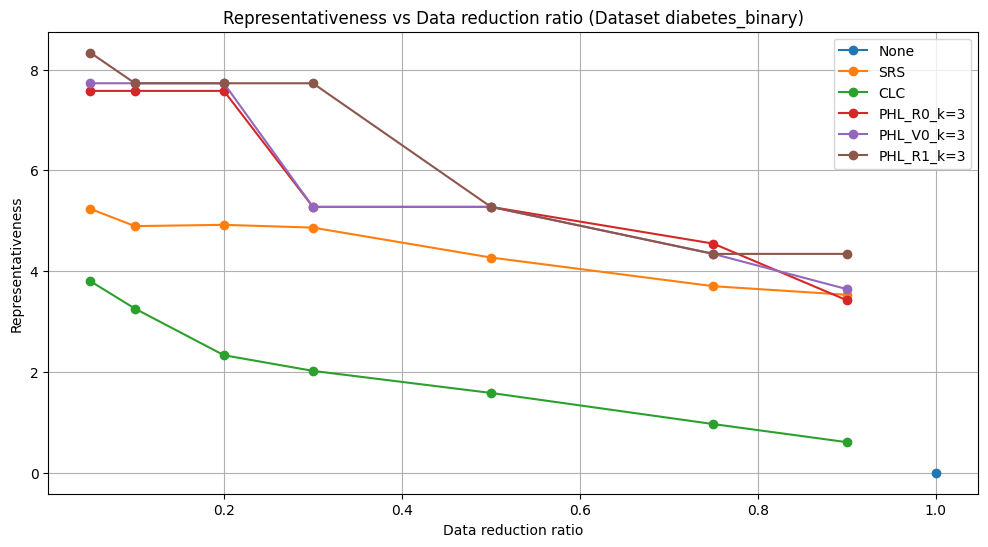

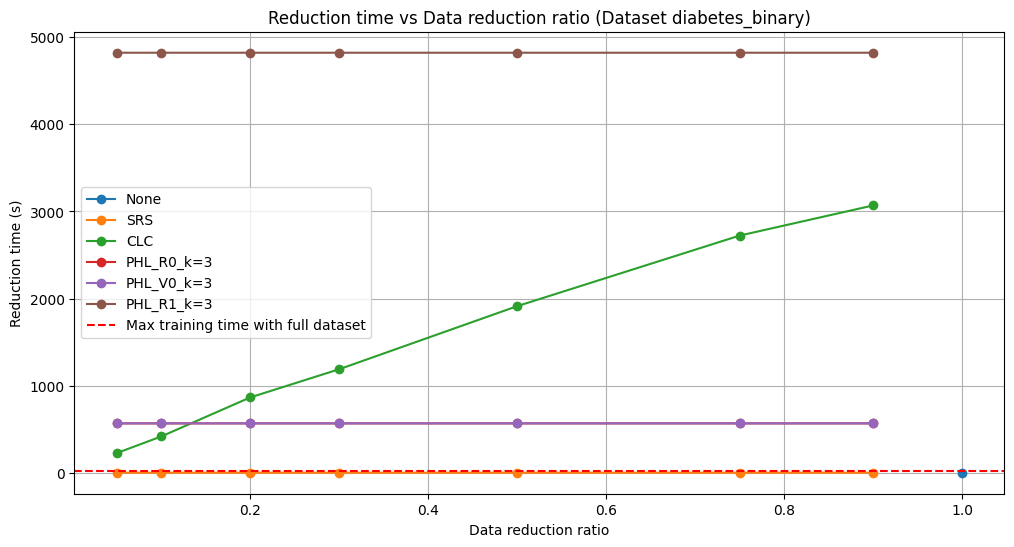

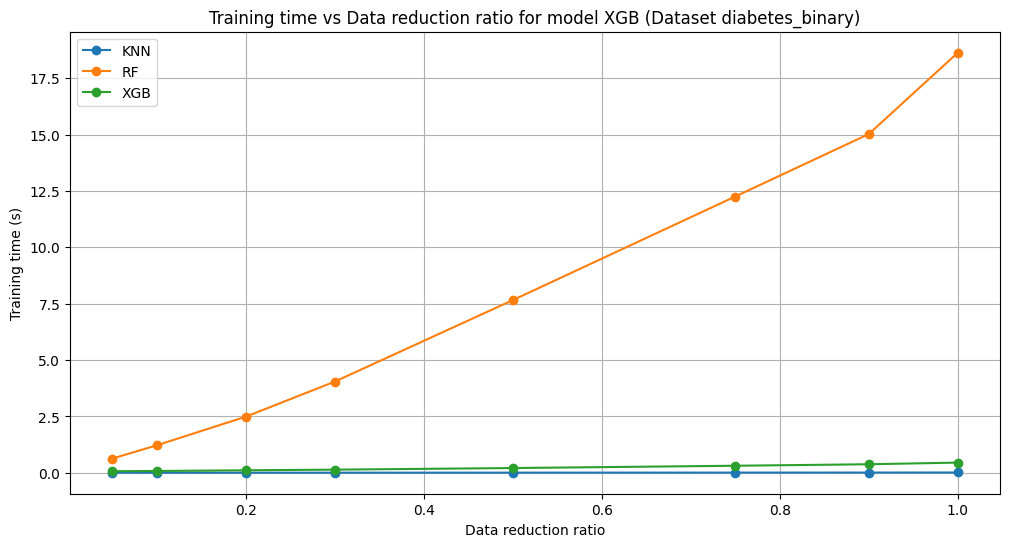

In [185]:
plot_representativeness('diabetes_binary')

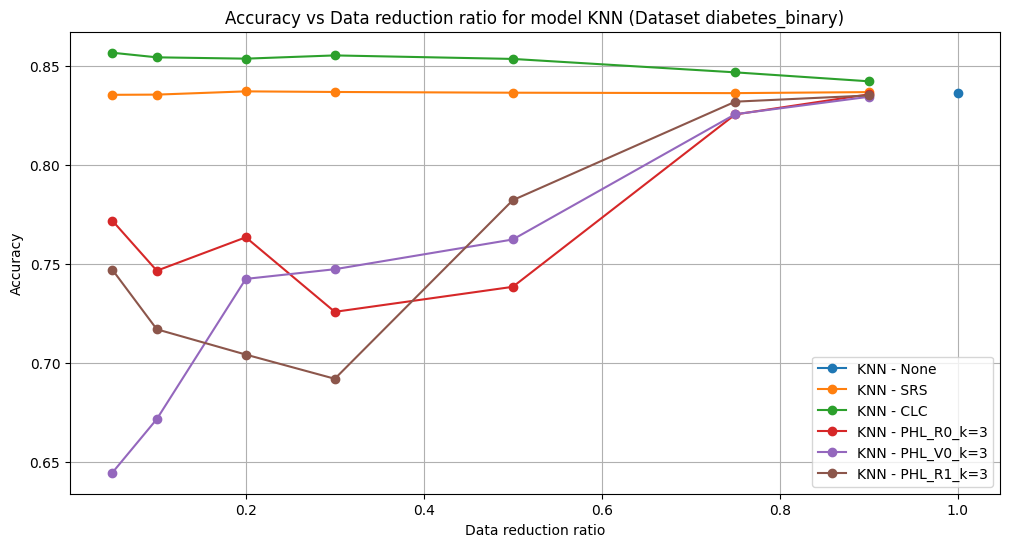

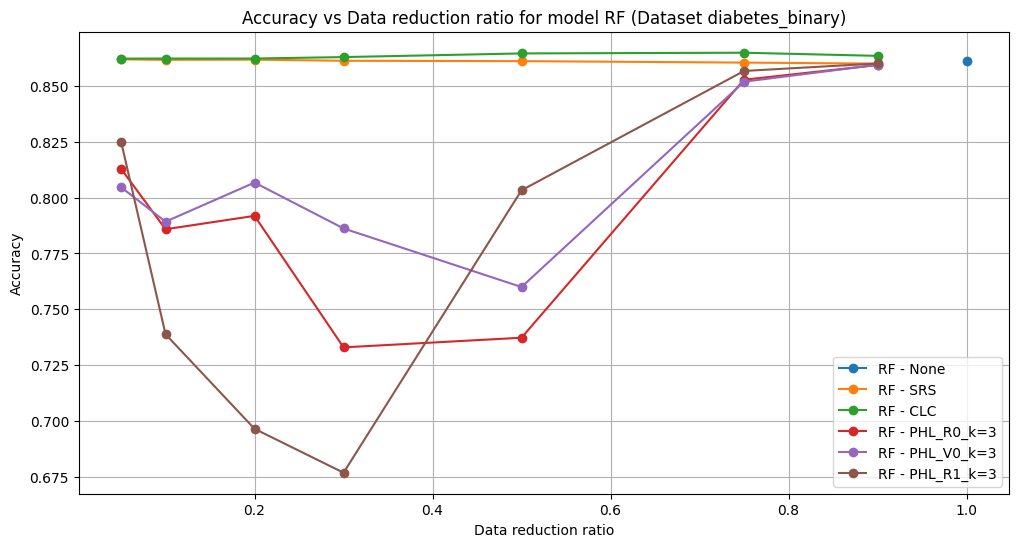

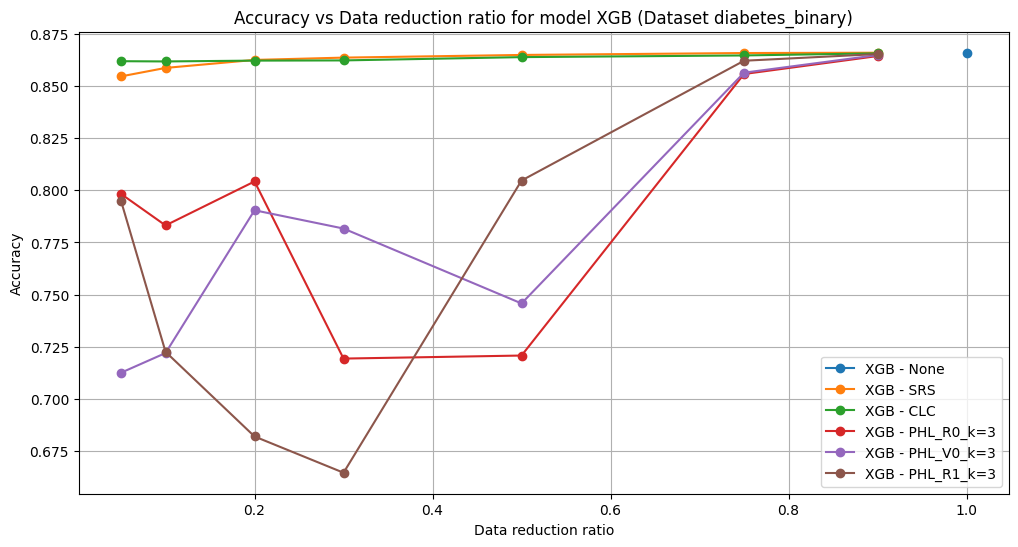

In [186]:
plot_accuracy('diabetes_binary')

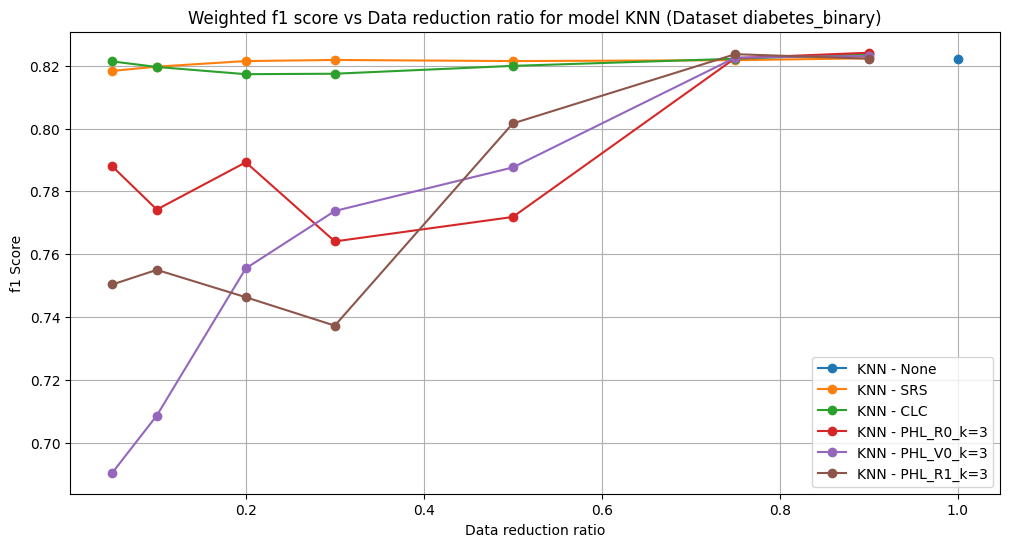

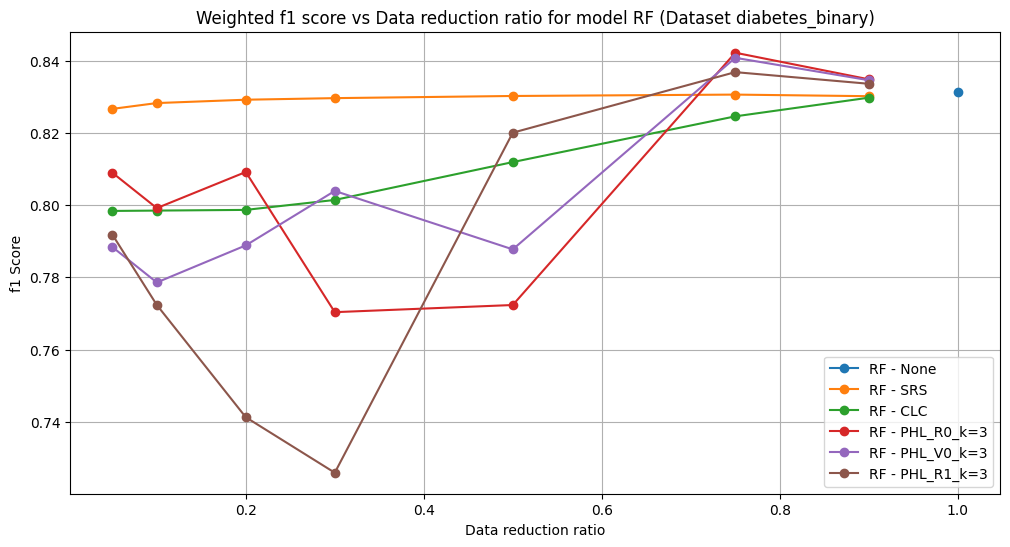

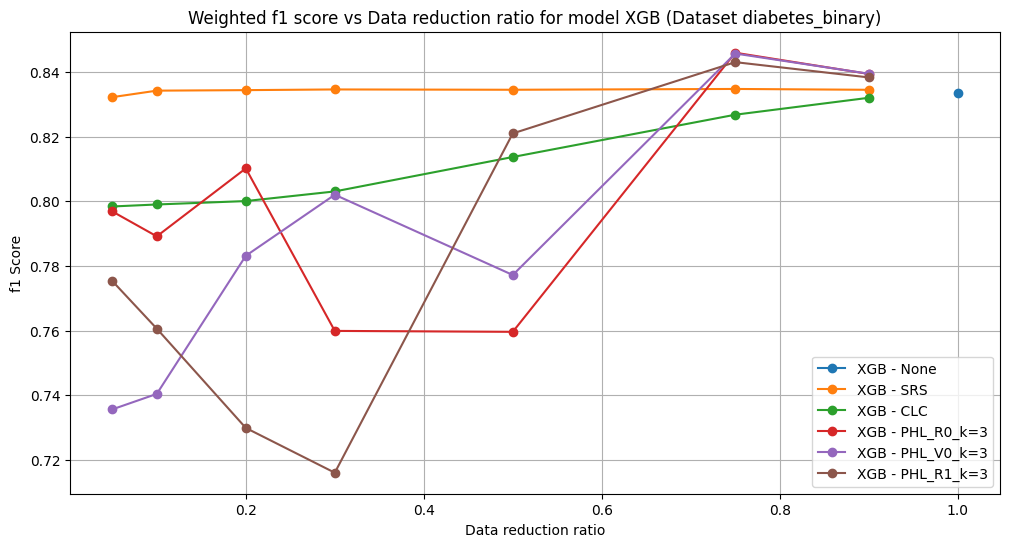

In [187]:
plot_f1('diabetes_binary')

In [188]:
# Obtain mean reduction time for each dataset for different phl methods
def mean_reduction_time():
    reduction_methods = ['PHL_R0_k=3', 'PHL_V0_k=3', 'PHL_R1_k=3']
    mean_times = {}
    
    for dbname, results in df_results.items():
        mean_times[dbname] = {}
        for method in reduction_methods:
            if method in results['reduction_method'].values:
                mean_time = results[results['reduction_method'] == method]['reduction_time'].mean()
                mean_times[dbname][method] = mean_time
            else:
                mean_times[dbname][method] = None
    
    return pd.DataFrame(mean_times)
mean_times_df = mean_reduction_time()

In [189]:
for row in mean_times_df.iterrows():
    print(f"{row[0]}: {row[1]}")

PHL_R0_k=3: pima                           0.090577
Dry bean                       1.880944
diabetes_binary_5050split     92.365246
diabetes_binary              566.392092
Name: PHL_R0_k=3, dtype: float64
PHL_V0_k=3: pima                           0.090572
Dry bean                       1.880949
diabetes_binary_5050split     92.365195
diabetes_binary              566.390227
Name: PHL_V0_k=3, dtype: float64
PHL_R1_k=3: pima                            0.130903
Dry bean                        2.448902
diabetes_binary_5050split     534.057903
diabetes_binary              4822.416620
Name: PHL_R1_k=3, dtype: float64


In [190]:
rf_training_times = [
        df_results[dbname][(df_results[dbname]['model'] == 'RF') & (df_results[dbname]['reduction_method'] == 'None')]['training_time'].values[0]
        for dbname, df in zip(dbnames, dfs)
    ]
clc_reduction_times = {p: [
        df_results[dbname][(df_results[dbname]['reduction_method'] == 'CLC') & (df_results[dbname]['percentage'] == p)]['reduction_time'].mean()
        for dbname, df in zip(dbnames, dfs)]
    for p in [0.1, 0.5]}

In [191]:
rf_training_times

[0.1135206222534179, 3.3710217475891118, 4.406138896942139, 18.63827085494995]

In [192]:
clc_reduction_times

{0.1: [0.0093109607696533,
  0.7913439273834229,
  14.519613981246948,
  416.078027009964],
 0.5: [0.0340135097503662,
  1.4073262214660645,
  58.12171530723572,
  1912.456925868988]}

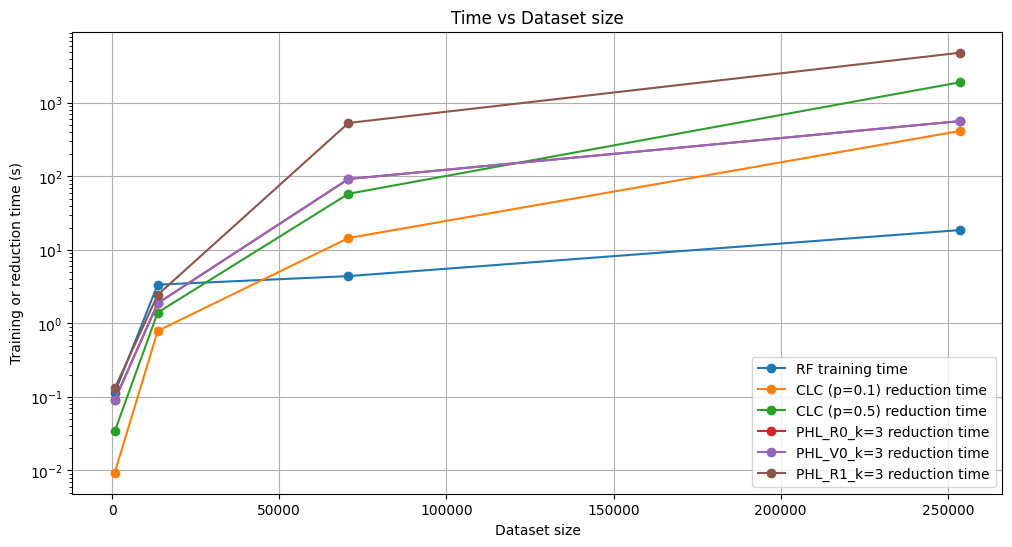

In [193]:
# Plot random forest training time with different full datasets from the results dataframes
def plot_rf_training_time():
    plt.figure(figsize=(12, 6))
    dataset_sizes = [df.shape[0] for df in dfs]
    rf_training_times = [
        df_results[dbname][(df_results[dbname]['model'] == 'RF') & (df_results[dbname]['reduction_method'] == 'None')]['training_time'].values[0]
        for dbname, df in zip(dbnames, dfs)
    ]
    clc_reduction_times = {p: [
        df_results[dbname][(df_results[dbname]['reduction_method'] == 'CLC') & (df_results[dbname]['percentage'] == p)]['reduction_time'].mean()
        for dbname, df in zip(dbnames, dfs)]
    for p in [0.1, 0.5]}
    plt.plot(dataset_sizes, rf_training_times, label='RF training time', marker='o')
    for p, clc_times in clc_reduction_times.items():
        plt.plot(dataset_sizes, clc_times, label=f'CLC (p={p}) reduction time', marker='o')
    for row in mean_times_df.iterrows():
        plt.plot(dataset_sizes, row[1].values, label=f'{row[0]} reduction time', marker='o')
    plt.title('Time vs Dataset size')
    plt.xlabel('Dataset size')
    plt.ylabel('Training or reduction time (s)')
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.savefig(f'../results/rf_training_time_vs_reduction_ratio.png')
    plt.show()
plot_rf_training_time()